In [1]:
import re
import numpy as np
import pandas as pd
from html import unescape
from scipy.stats import skew

In [2]:
df = pd.read_csv('data/data_kaggle.csv')

df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


In [3]:
# Remove 'RM" and convert to numeric
df['Price'] = df['Price'].str.replace('RM', '').str.replace(',', '').astype(float)
df['Price']

0        1250000.0
1        6800000.0
2        1030000.0
3              NaN
4         900000.0
           ...    
53878    5100000.0
53879    5000000.0
53880    5500000.0
53881     480000.0
53882     540000.0
Name: Price, Length: 53883, dtype: float64

In [4]:
df[df['Price'] < 100000]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
922,"KLCC, Kuala Lumpur",1800.0,Studio,1.0,NaN,Serviced Residence (Intermediate),Built-up : 493 sq. ft.,Partly Furnished
923,"KLCC, Kuala Lumpur",1800.0,Studio,1.0,NaN,Serviced Residence (Intermediate),Built-up : 493 sq. ft.,Partly Furnished
1196,"KLCC, Kuala Lumpur",7500.0,2,2.0,1.0,Serviced Residence (Intermediate),"Built-up : 1,078 sq. ft.",Fully Furnished
1878,"Bukit Bintang, Kuala Lumpur",3000.0,1,1.0,1.0,Condominium (Intermediate),Built-up : 538 sq. ft.,Fully Furnished
2549,"KLCC, Kuala Lumpur",8000.0,3+2,5.0,NaN,Serviced Residence (Corner),"Built-up : 2,096 sq. ft.",Fully Furnished
...,...,...,...,...,...,...,...,...
52935,"Sri Petaling, Kuala Lumpur",1100.0,3,2.0,1.0,Condominium,Built-up : 850 sq. ft.,Partly Furnished
52996,"Bangsar, Kuala Lumpur",3500.0,3+1,3.0,1.0,Condominium,"Built-up : 1,300 sq. ft.",Fully Furnished
53086,"Bangsar South, Kuala Lumpur",2600.0,2,2.0,1.0,Serviced Residence,NaN,Fully Furnished
53095,"Mont Kiara, Kuala Lumpur",4000.0,Studio,1.0,NaN,Serviced Residence (Intermediate),Land area : 1540 sq. ft.,Fully Furnished


In [5]:
df = df[df['Price'] >= 100000]
df[df['Price'] < 100000]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing


In [6]:
# Only take the district name
df['Location'] = df['Location'].str.replace(', Kuala Lumpur', '').str.upper()

In [7]:
# Clean Rooms column
def clean_rooms(rooms):
    if pd.isna(rooms):
        return None
    match = re.match(r"(\d+)(\+(\d+))?", rooms)
    if match:
        main_rooms = int(match.group(1))
        additional_rooms = int(match.group(3)) if match.group(3) else 0
        return main_rooms + additional_rooms
    return None

df['Rooms'] = df['Rooms'].apply(clean_rooms)
df['Rooms']

0        3.0
1        6.0
2        3.0
4        5.0
5        6.0
        ... 
53878    6.0
53879    5.0
53880    6.0
53881    3.0
53882    4.0
Name: Rooms, Length: 53215, dtype: float64

In [8]:
# Update the Size extraction function to handle different formats
def extract_size(size):
    if pd.isna(size):
        return None

    # Convert special HTML entities to their corresponding symbols
    size = unescape(size)

    # Match width x length (with optional area in parentheses) format
    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+)\s*\((\d+)\s*sf\).*", size)
    if match:
        return int(match.group(3))

    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+).*", size)
    if match:
        width = int(match.group(1))
        length = int(match.group(2))
        return width * length

    # Match range format and take the average
    match = re.match(r".*?(\d+)\s*[-~]\s*(\d+).*", size)
    if match:
        low = int(match.group(1))
        high = int(match.group(2))
        return (low + high) / 2

    # Match single numeric value
    match = re.search(r"(\d[\d,]*)\s*sq\.?\s*ft\.?", size)
    if match:
        return int(match.group(1).replace(',', ''))

    return None

df['Size'] = df['Size'].apply(extract_size)
df['Size']

0         1335.0
1         6900.0
2         1875.0
4         1513.0
5         7200.0
          ...   
53878     7168.0
53879    15000.0
53880     7168.0
53881     1150.0
53882     1313.0
Name: Size, Length: 53215, dtype: float64

In [9]:
df.isna().sum()

Location             0
Price                0
Rooms             2488
Bathrooms         1940
Car Parks        17318
Property Type        0
Size              1273
Furnishing        6772
dtype: int64

In [10]:
df = df.dropna(subset=['Price'])

In [11]:
# Fill missing values with median for numeric columns
df['Rooms'] = df['Rooms'].fillna(df['Rooms'].median())
df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())
df['Size'] = df['Size'].fillna(df['Size'].median())

# Fill missing Car Parks with 0
df['Car Parks'] = df['Car Parks'].fillna(0)

# Fill missing and Unknown Furnishing with 'Unfurnished'
df['Furnishing'] = df['Furnishing'].fillna('Unfurnished')
df['Furnishing'] = df['Furnishing'].replace('Unknown', 'Unfurnished')

In [12]:
# Generalize Property Type
def generalize_property_type(property_type):
    if pd.isna(property_type):
        return None
    
    # General property types
    mappings = {
        "1-sty Terrace/Link House": "1-sty Terrace/Link House",
        "1.5-sty Terrace/Link House": "1.5-sty Terrace/Link House",
        "2-sty Terrace/Link House": "2-sty Terrace/Link House",
        "2.5-sty Terrace/Link House": "2.5-sty Terrace/Link House",
        "3-sty Terrace/Link House": "3-sty Terrace/Link House",
        "3.5-sty Terrace/Link House": "3.5-sty Terrace/Link House",
        "4-sty Terrace/Link House": "4-sty Terrace/Link House",
        "4.5-sty Terrace/Link House": "4.5-sty Terrace/Link House",
        "Serviced Residence": "Serviced Residence",
        "Condominium": "Condominium",
        "Bungalow": "Bungalow",
        "Townhouse": "Townhouse",
        "Semi-detached House": "Semi-detached House",
        "Apartment": "Apartment",
        "Studio": "Studio",
        "Flat": "Flat",
        "Cluster House": "Cluster House",
        "Residential Land": "Residential Land"
    }
    
    for key in mappings:
        if key in property_type:
            return mappings[key]
    return property_type

df['Property Type'] = df['Property Type'].apply(generalize_property_type)
df['Property Type'].unique()

array(['Serviced Residence', 'Bungalow', 'Condominium',
       'Semi-detached House', '2-sty Terrace/Link House', 'Apartment',
       '3-sty Terrace/Link House', '2.5-sty Terrace/Link House',
       '3.5-sty Terrace/Link House', '1-sty Terrace/Link House',
       '1.5-sty Terrace/Link House', '4-sty Terrace/Link House',
       'Townhouse', 'Residential Land', '4.5-sty Terrace/Link House',
       'Flat', 'Cluster House'], dtype=object)

In [13]:
df['Property Type'].value_counts()

Property Type
Condominium                   23013
Serviced Residence            13259
2-sty Terrace/Link House       4172
Bungalow                       3708
Semi-detached House            2148
3-sty Terrace/Link House       1679
Apartment                      1654
1-sty Terrace/Link House        830
2.5-sty Terrace/Link House      737
Residential Land                729
Townhouse                       544
Flat                            368
3.5-sty Terrace/Link House      188
1.5-sty Terrace/Link House       98
4-sty Terrace/Link House         57
4.5-sty Terrace/Link House       22
Cluster House                     9
Name: count, dtype: int64

In [14]:
# Filter out rare property types with less than 100 instances
property_type_counts = df['Property Type'].value_counts()
rare_property_types = property_type_counts[property_type_counts < 200].index
df = df[~df['Property Type'].isin(rare_property_types)]

In [15]:
df['Property Type'].value_counts()

Property Type
Condominium                   23013
Serviced Residence            13259
2-sty Terrace/Link House       4172
Bungalow                       3708
Semi-detached House            2148
3-sty Terrace/Link House       1679
Apartment                      1654
1-sty Terrace/Link House        830
2.5-sty Terrace/Link House      737
Residential Land                729
Townhouse                       544
Flat                            368
Name: count, dtype: int64

In [16]:
df['Furnishing'].value_counts()

Furnishing
Partly Furnished    26187
Fully Furnished     13665
Unfurnished         12989
Name: count, dtype: int64

Outliers detected in Price using Z-Score method: 84
Outliers detected in Rooms using Z-Score method: 194
Outliers detected in Size using Z-Score method: 24
Outliers detected in Price using IQR method: 5060
Outliers detected in Rooms using IQR method: 8093
Outliers detected in Size using IQR method: 5536


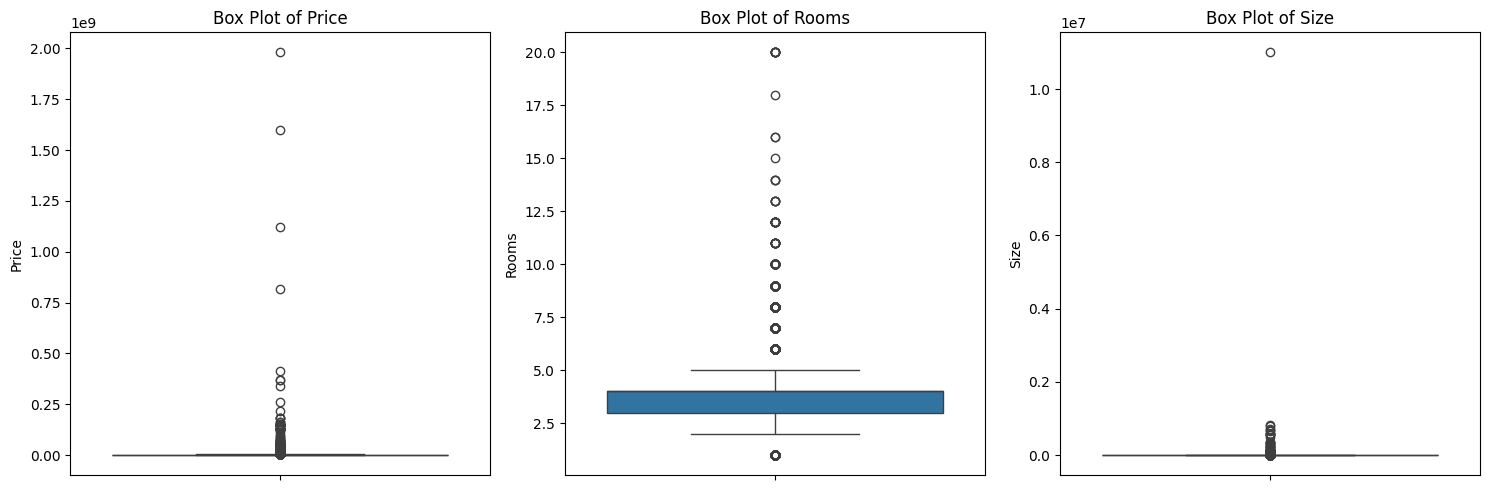

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Detect outliers using Z-Score
def detect_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    return np.where(np.abs(z_scores) > threshold)

# Detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))

# Columns to check for outliers
numeric_columns = ['Price', 'Rooms', 'Size']

# Z-Score method
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    print(f'Outliers detected in {col} using Z-Score method: {len(outliers_zscore[0])}')

# IQR method
for col in numeric_columns:
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers detected in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Outliers remaining in Price using Z-Score method: 0
Outliers remaining in Price using IQR method: 5057
Outliers remaining in Rooms using Z-Score method: 0
Outliers remaining in Rooms using IQR method: 0
Outliers remaining in Size using Z-Score method: 0
Outliers remaining in Size using IQR method: 0


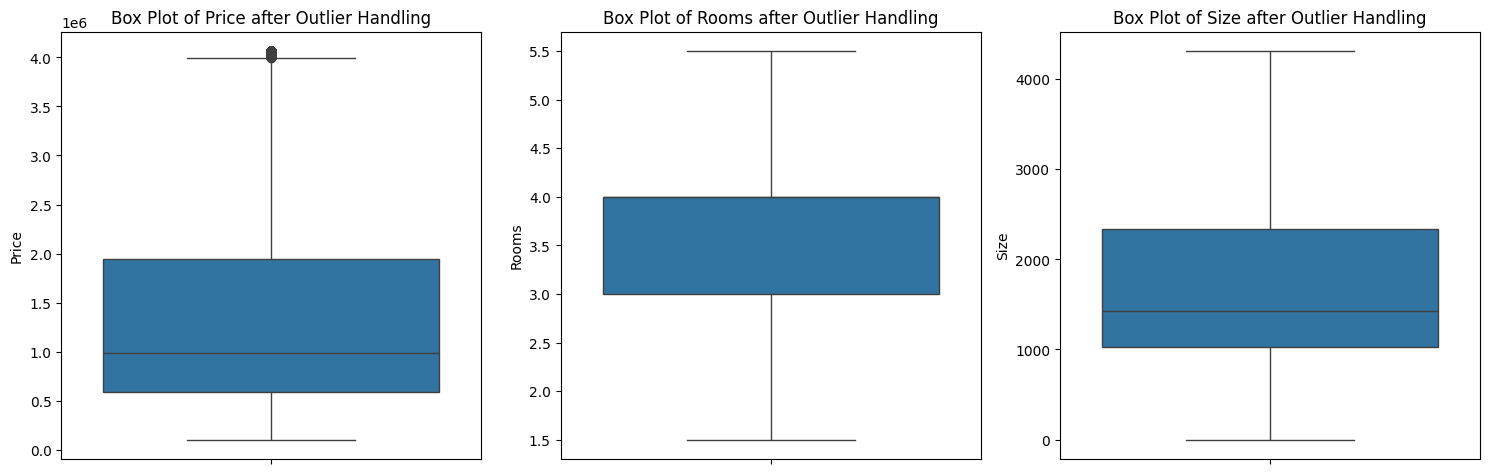

In [18]:
# Remove extreme outliers
def remove_extreme_outliers(df, col):
    outliers_zscore = set(detect_outliers_zscore(df[col].dropna())[0])
    outliers_iqr = set(detect_outliers_iqr(df[col].dropna())[0])
    extreme_outliers = outliers_zscore.intersection(outliers_iqr)
    return df.drop(index=df.iloc[list(extreme_outliers)].index)

# Cap remaining outliers to IQR bounds
def cap_outliers(df, col):
    Q1 = np.percentile(df[col].dropna(), 25)
    Q3 = np.percentile(df[col].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

for col in numeric_columns:
    df = remove_extreme_outliers(df, col)
    df = cap_outliers(df, col)

# Verify the changes 
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers remaining in {col} using Z-Score method: {len(outliers_zscore[0])}')
    print(f'Outliers remaining in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col} after Outlier Handling')
plt.tight_layout()
plt.show()

In [19]:
df.to_csv('data/cleaned_data.csv')

In [20]:
# Perform one-hot encoding on updated categorical variables
encoded_df = pd.get_dummies(df, columns=['Location', 'Property Type', 'Furnishing'], drop_first=False)

In [21]:
encoded_df

,Price,Rooms,Bathrooms,Car Parks,Size,Location_ADIVA DESA PARKCITY,Location_ALAM DAMAI,Location_AMPANG,Location_AMPANG HILIR,Location_BANDAR DAMAI PERDANA,...,Property Type_Bungalow,Property Type_Condominium,Property Type_Flat,Property Type_Residential Land,Property Type_Semi-detached House,Property Type_Serviced Residence,Property Type_Townhouse,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished
0,1250000.0,3.0,3.0,2.0,1335.0,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,4065000.0,5.5,7.0,0.0,4307.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,1030000.0,3.0,4.0,2.0,1875.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,900000.0,5.0,3.0,2.0,1513.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
5,4065000.0,5.5,5.0,4.0,4307.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53878,4065000.0,5.5,4.0,0.0,4307.0,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
53879,4065000.0,5.0,4.0,0.0,4307.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
53880,4065000.0,5.5,4.0,0.0,4307.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
53881,480000.0,3.0,2.0,0.0,1150.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True


In [22]:
encoded_df.to_csv('data/encoded_data.csv', index=False)

In [23]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [24]:
X = encoded_df.drop(columns=['Price'])
y = encoded_df['Price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_score = linear_model.score(X_test, y_test)
print(f"Linear Regression score: {linear_model_score}")

# Cross-Validation for Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring='r2')
print(f"Linear Regression Cross-Validation scores: {linear_cv_scores}")
print(f"Linear Regression Cross-Validation Mean score: {np.mean(linear_cv_scores)}")

Linear Regression score: 0.8588851240106704
Linear Regression Cross-Validation scores: [0.85888512 0.85259979 0.85041002 0.85794292 0.85470235]
Linear Regression Cross-Validation Mean score: 0.8549080390924377


In [27]:
# Predictions
y_pred_linear = linear_model.predict(X_test)

# Residuals for Linear Regression
residuals_linear = y_test - y_pred_linear

In [28]:
# Random Forest Regressor Model
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-Validation for Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='r2')
print(f"Random Forest Cross-Validation scores: {rf_cv_scores}")
print(f"Random Forest Cross-Validation Mean score: {np.mean(rf_cv_scores)}")

Random Forest Cross-Validation scores: [0.93977303 0.94132554 0.93442991 0.93540433 0.93378301]
Random Forest Cross-Validation Mean score: 0.9369431651220745


In [29]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model.fit(X_train_scaled, y_train)

rf_model_score = rf_model.score(X_test_scaled, y_test)
print(f"Random Forest score: {rf_model_score}")

y_pred_rf = rf_model.predict(X_test_scaled)

Random Forest score: 0.9398686326389094


In [30]:
# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Residuals for Random Forest
residuals_rf = y_test - y_pred_rf

In [31]:
# Fit the Random Forest model on the entire dataset
rf_model.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [32]:
import matplotlib.pyplot as plt

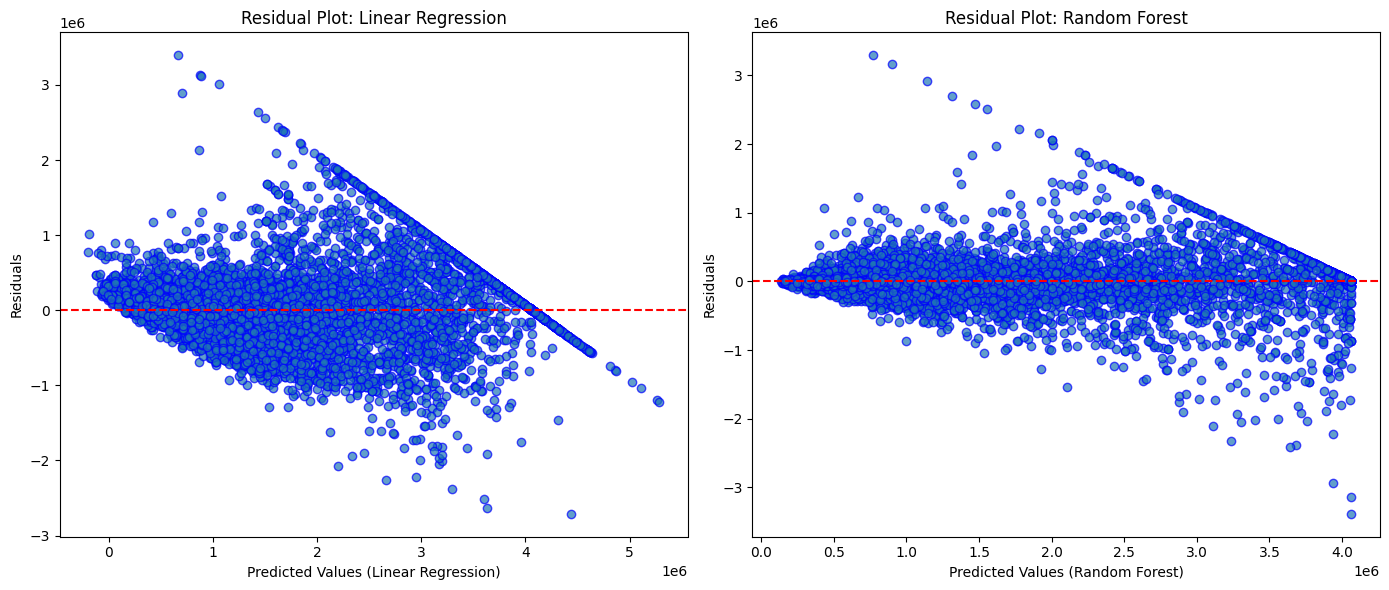

In [33]:
y_pred_linear = linear_model.predict(X_test)
residuals_linear = y_test - y_pred_linear
residuals_rf = y_test - y_pred_rf

# Plotting the Residual Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_linear, residuals_linear, alpha=0.7, edgecolors='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (Linear Regression)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Linear Regression')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_rf, residuals_rf, alpha=0.7, edgecolors='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (Random Forest)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Random Forest')

plt.tight_layout()
plt.show()


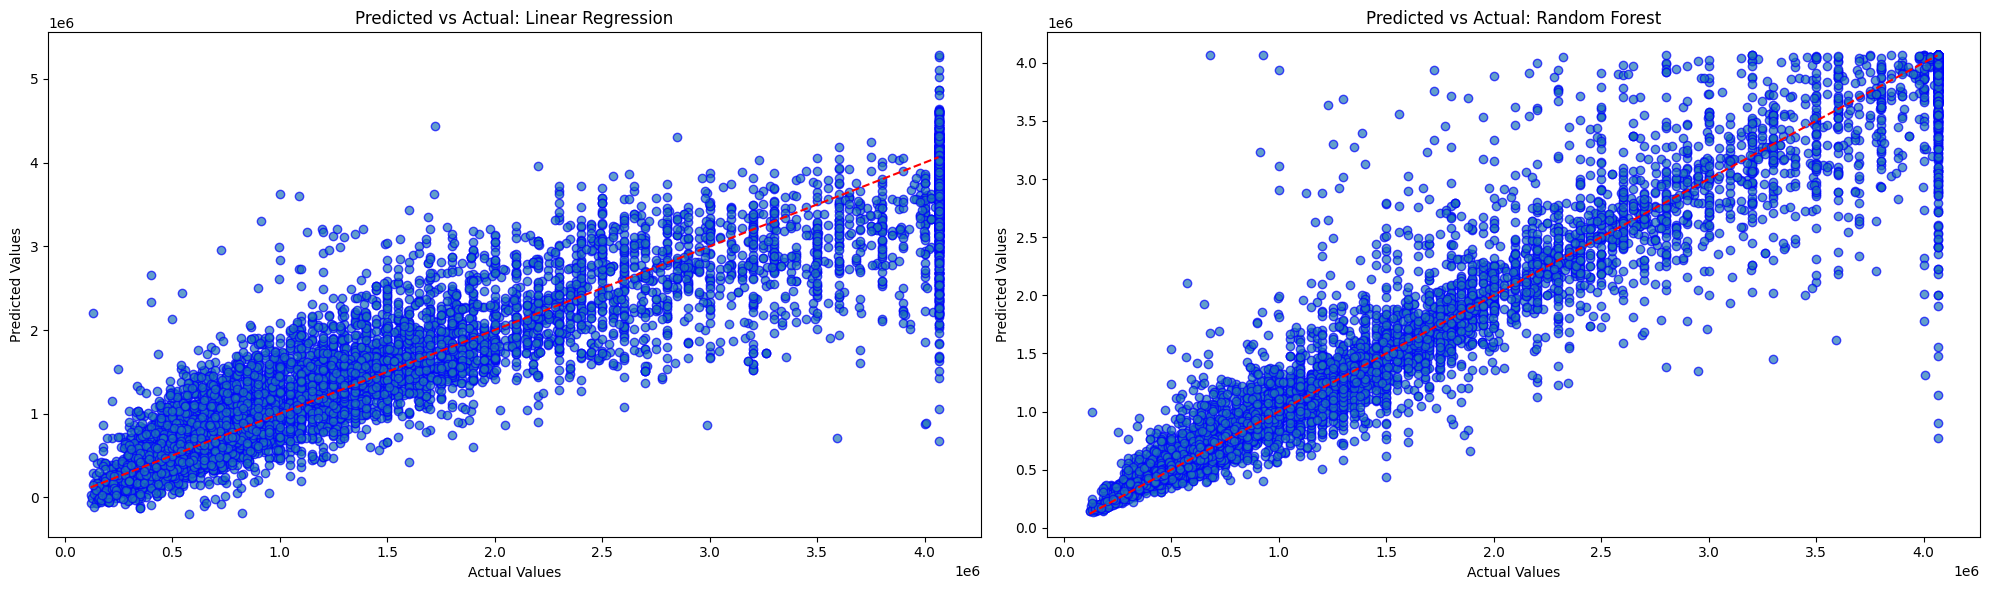

In [34]:
# Plotting Predicted vs Actual Values
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Linear Regression')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Random Forest')

plt.tight_layout()
plt.show()

In [35]:
# Save the trained model and scaler
joblib.dump(rf_model, 'joblibs/rf_model.joblib')
joblib.dump(scaler, 'joblibs/scaler.joblib')
joblib.dump(X.columns, 'joblibs/feature_columns.joblib')

['joblibs/feature_columns.joblib']

In [36]:
import gzip
import shutil

# Compress model file
def compress_model(input_file, output_file):
    with open(input_file, 'rb') as f_in:
        with gzip.open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

compress_model('joblibs/rf_model.joblib', 'joblibs/rf_model.joblib.gz')